In [1]:
import numpy as np
import torch
import random
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [2]:
grid_r, grid_c = 5, 5
state_num = grid_r * grid_c
action_num = 5
r_other_step = 0.0
r_forbidden = -10.0
r_target = 1.0
r_boundary = -10.0
gamma=0.9
dr=np.array([-1,0,1,0,0])
dc=np.array([0,1,0,-1,0])


reward = np.array([
    [r_other_step, r_other_step, r_other_step, r_other_step, r_other_step],
    [r_other_step, r_forbidden, r_forbidden, r_other_step, r_other_step],
    [r_other_step, r_other_step, r_forbidden, r_other_step, r_other_step],
    [r_other_step, r_forbidden, r_target, r_forbidden, r_other_step],
    [r_other_step, r_forbidden, r_other_step, r_other_step, r_other_step]
])
policy_b = np.ones((state_num, action_num)) * 0.2  # behavior policy

In [3]:

def s2grid(s):
    return s//grid_c,s%grid_c

def grid2s(r,c):
    return r*grid_c+c

def gen_action(s,policy_b):
    prob=policy_b[s]
    rand_num = random.random()
    cumulative_prob = np.cumsum(prob)
    selected_action = np.argmax(rand_num < cumulative_prob)
    return selected_action

def gen_sample(reward,policy_b,sample_num):
    s=random.randint(0,state_num-1)  # init s
    a=gen_action(s,policy_b)
    buffer=[]

    next_s,next_action,cur_reward=-1,-1,-1
    for _ in range(sample_num):
        r,c=s2grid(s)
        next_r=r+dr[a]
        next_c=c+dc[a]
        if(next_r<0 or next_r>=grid_r or next_c<0 or next_c>=grid_c):#撞墙
            next_s=s
            cur_reward=r_boundary
        else:
            next_s=grid2s(next_r,next_c)
            cur_reward=reward[next_r,next_c]
        
        buffer.append((s,a,cur_reward,next_s))
        s=next_s
        a=gen_action(s,policy_b)
    
    return buffer

In [4]:
class MyDataset(Dataset):
    def __init__(self,buffer):
        self.buf=[s2grid(s)+(a,cur_reward,next_s) for s,a,cur_reward,next_s in buffer]

        self.buf=torch.tensor(self.buf)
        # print(self.buf.shape)

        
    def __len__(self):
        return len(self.buf)
        
    def __getitem__(self,index):
        return self.buf[index]

In [5]:

# buffer=gen_sample(reward=reward,policy_b=policy_b,sample_num=1000)
# dataset=MyDataset(buffer)
# dataloader=DataLoader(dataset,batch_size=batch_size,shuffle=True,num_workers=4)

In [6]:
class DuelDQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1=nn.Linear(2,128)
        self.relu=nn.ReLU()
        self.linear2=nn.Linear(128,action_num+1)
    def forward(self,X):
        X=self.linear2(self.relu(self.linear1(X)))#这里得到的X.size=(bs,6)
        V=X[:,-1]
        A=X[:,:-1]
        A=A-torch.mean(A,dim=1,keepdim=True)
        return V.reshape((A.shape[0],1))+A #广播

In [7]:

# model=nn.Sequential(
#     nn.Linear(2,100),
#     nn.ReLU(),
#     nn.Linear(100,5)
# )

# model_T=nn.Sequential(
#     nn.Linear(2,100),
#     nn.ReLU(),
#     nn.Linear(100,5)
# )
model=DuelDQN()
model_T=DuelDQN()

In [8]:
batch_size=100
buffer=gen_sample(reward=reward,policy_b=policy_b,sample_num=2000)
count=[0]*25
for s,a,cur_reward,next_s in buffer:
    count[s]+=1
print(count)
dataset=MyDataset(buffer)
def get_minibatch(batch_size,dataset):#数据有放回
    random_index = [random.randint(0, len(dataset)-1) for _ in range(batch_size)]
    return dataset[random_index]

def copy_parm(model,model_T):
    model_T.load_state_dict(model.state_dict())

def get_y_T(data,model_T,model):#data bs,5   r,c,a,reward,next_s
    with torch.no_grad():
        batch_size=data.shape[0]
        next_s=data[:,4]
        next_r,next_c=next_s//grid_c,next_s%grid_c
        
        # next_r=torch.repeat_interleave(next_r.reshape((batch_size,1)),repeats=action_num,dim=0)
        # next_c=torch.repeat_interleave(next_c.reshape((batch_size,1)),repeats=action_num,dim=0)
        # action=torch.arange(action_num).reshape((action_num,1)).repeat((batch_size,1))
        input=torch.concat([next_r.reshape((batch_size,1)),next_c.reshape((batch_size,1))],dim=1).float()
        output=model_T(normalize_input(input))
        max_q,_ = torch.max(output,dim=1,keepdim=True)
        return data[:,3].reshape((batch_size,-1))+gamma*max_q  #y_T=r+gamma*maxq

def double_dqn_get_y_T(data,model_T,model):#data bs,5   r,c,a,reward,next_s
    with torch.no_grad():
        batch_size=data.shape[0]
        next_s=data[:,4]
        next_r,next_c=next_s//grid_c,next_s%grid_c
        
        # next_r=torch.repeat_interleave(next_r.reshape((batch_size,1)),repeats=action_num,dim=0)
        # next_c=torch.repeat_interleave(next_c.reshape((batch_size,1)),repeats=action_num,dim=0)
        # action=torch.arange(action_num).reshape((action_num,1)).repeat((batch_size,1))
        input=torch.concat([next_r.reshape((batch_size,1)),next_c.reshape((batch_size,1))],dim=1).float()
        output=model(normalize_input(input))
        # print(output.shape,output)
        _,max_action = torch.max(output,dim=1)
        # print(max_action[:5])
        output_T=model_T(normalize_input(input))

        # print(output_T[:5])
        
        max_q=output[[i for i in range(batch_size)],max_action].reshape((batch_size,1))
        # print(max_q[:5])
        
        return data[:,3].reshape((batch_size,-1))+gamma*max_q  #y_T=r+gamma*maxq

def normalize_input(input):
    return input

def normalize_y_T(input):
    return input

def closed_form_solution(action):
    V_target=np.array([
    [3.4868, 3.8742, 4.3047, 4.7830, 5.3144],
    [3.1381, 3.4868, 4.7830, 5.3144, 5.9049],
    [2.8243, 2.5419, 10.0000, 5.9049, 6.5610],
    [2.5419, 10.0000, 10.0000, 10.0000, 7.2900],
    [2.2877, 9.0000, 10.0000, 9.0000, 8.1000]
]).reshape((state_num,1))
    
    P=np.zeros((state_num,state_num))
    R=np.zeros((state_num))
    for i in range(grid_c):
        for j in range(grid_r):
            next_r,next_c=i+dr[action[i,j]],j+dc[action[i,j]]
            s1=grid2s(i,j)
            if(next_r<0 or next_r>=grid_r or next_c<0 or next_c>=grid_c):
                P[s1,s1]=1
                R[s1]=r_boundary
            else:
                s2=grid2s(next_r,next_c)
                P[s1,s2]=1
                R[s1]=reward[next_r][next_c]

    I=np.eye(state_num)
    V=np.linalg.inv(I-gamma*P)@R
    # print(V.reshape(grid_r,grid_c))
    return np.sqrt(np.mean((V-V_target)**2))


def output_result(model):
    with torch.no_grad():
    
        r=torch.repeat_interleave(torch.arange(grid_r).reshape((grid_r,1)),repeats=grid_c,dim=0)
        c=torch.arange(grid_c).reshape((grid_c,1)).repeat((grid_r,1))
        rc=torch.concat([r,c],dim=1).float()
        # rc=torch.repeat_interleave(rc,repeats=action_num,dim=0)
        # action=torch.arange(action_num).reshape((action_num,1)).repeat((state_num,1))
        # input=torch.concat([rc,action],dim=1).float()
        # print(input.shape,input[:10])
        return model(rc)  #返回的是动作值矩阵(state_num,action_num)

[52, 42, 59, 84, 81, 64, 82, 94, 69, 67, 75, 90, 89, 74, 86, 91, 108, 87, 78, 66, 111, 110, 96, 75, 70]


In [9]:
num_steps=15000
lr=0.005

copy_parm(model=model,model_T=model_T)
model_T.eval()
loss=nn.MSELoss()
optimizer=torch.optim.AdamW(model.parameters(), lr=lr)
rmse_list=[]
loss_list=[]
for i in range(num_steps):
    model.train()
    data=get_minibatch(batch_size=batch_size,dataset=dataset)
    # print(data)
    # y_T=get_y_T(data,model_T,model).float()
    y_T=double_dqn_get_y_T(data,model_T,model).float()
    y_T=normalize_y_T(y_T)
    # print(normalize_input(data[:,:3]))
    y=model(normalize_input(data[:,:2]).float())
    action_index=data[:,2]
    # print(action_index)
    
    row_index=torch.arange(y.shape[0])

    y=y[row_index,action_index.long()].reshape((y.shape[0],1))
    l=loss(y,y_T)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    
    if i==6000 or i==10000:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.5

    if i%1000==0:
        print("step ",i,", loss ",l.item())
    if i%50==0:
        copy_parm(model=model,model_T=model_T)
    if i%1==0:
        q=output_result(model)
        _ , final_action = torch.max(q,dim=1)
        # closed_form_solution(final_action.reshape((grid_r,grid_c)).numpy())
        loss_list.append(l.item())
        rmse_list.append(closed_form_solution(final_action.reshape((grid_r,grid_c)).numpy()))

step  0 , loss  39.63359451293945
step  1000 , loss  9.932085990905762
step  2000 , loss  5.85368537902832
step  3000 , loss  2.8422255516052246
step  4000 , loss  1.624613642692566
step  5000 , loss  1.8297604322433472
step  6000 , loss  0.44472283124923706
step  7000 , loss  0.32745444774627686
step  8000 , loss  0.16221600770950317
step  9000 , loss  0.17343609035015106
step  10000 , loss  0.08587753027677536
step  11000 , loss  0.057601895183324814
step  12000 , loss  0.035313501954078674
step  13000 , loss  0.02963874489068985
step  14000 , loss  0.015779944136738777


In [10]:
torch.set_printoptions(sci_mode=False)
def output_result(model):
    with torch.no_grad():
    
        r=torch.repeat_interleave(torch.arange(grid_r).reshape((grid_r,1)),repeats=grid_c,dim=0)
        c=torch.arange(grid_c).reshape((grid_c,1)).repeat((grid_r,1))
        rc=torch.concat([r,c],dim=1).float()
        # rc=torch.repeat_interleave(rc,repeats=action_num,dim=0)
        # action=torch.arange(action_num).reshape((action_num,1)).repeat((state_num,1))
        # input=torch.concat([rc,action],dim=1).float()
        # print(input.shape,input[:10])
        return model(rc)  #返回的是动作值矩阵(state_num,action_num)


q=output_result(model)


In [11]:
_ , final_action = torch.max(q,dim=1)
final_action.reshape((grid_r,grid_c))

tensor([[1, 1, 1, 1, 2],
        [0, 0, 1, 1, 2],
        [0, 3, 2, 1, 2],
        [0, 1, 4, 3, 2],
        [0, 1, 0, 3, 3]])

In [12]:
torch.set_printoptions(sci_mode=False)
q

tensor([[-7.2216,  3.0522,  2.3095, -7.2466,  2.6739],
        [-7.1433,  3.4839, -7.3036,  2.7413,  2.9099],
        [-6.5563,  3.7856, -6.2951,  2.9376,  3.3230],
        [-6.3040,  4.2646,  4.0949,  3.3799,  3.8359],
        [-5.9650, -5.7712,  4.6104,  3.9229,  4.1648],
        [ 2.7227, -7.2544,  2.1432, -7.6770,  2.2693],
        [ 2.9796, -6.2367,  1.8205,  2.3176, -7.3249],
        [ 3.2993,  4.2237, -1.9593, -7.3275, -6.2778],
        [ 3.9073,  4.5635,  4.5308, -5.9355,  4.0219],
        [ 4.0588, -5.2749,  5.1638,  4.0286,  4.6183],
        [ 2.4954,  1.9680,  1.8508, -7.8807,  2.1331],
        [-7.3210, -2.0114, -2.0745,  2.0875,  1.9205],
        [-6.1377,  4.5995,  8.9616,  1.9836, -2.1012],
        [ 3.7644,  5.1410, -2.1543, -2.1600,  4.3829],
        [ 4.6586, -4.9480,  5.6962,  4.7100,  5.0594],
        [ 2.1733, -2.0106,  1.6020, -8.0569,  1.7524],
        [ 2.0600,  8.9142, -2.6332,  1.7993, -2.1668],
        [-2.1910, -2.1384,  7.9538, -2.1375,  8.6537],
        [ 

In [13]:
closed_form_solution(final_action.reshape((grid_r,grid_c)).numpy())

3.8398010297820013

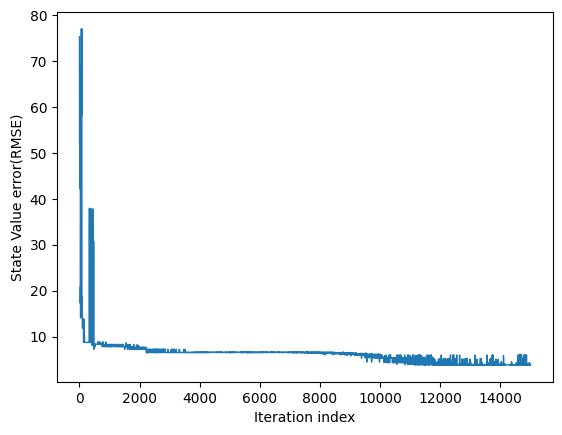

In [14]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontManager

x_axis=[i for i in range(num_steps)]
# plt.plot(x_axis, loss_list)
plt.plot(x_axis, rmse_list,linewidth = 1)
plt.xlabel('Iteration index')
plt.ylabel('State Value error(RMSE)')
plt.show()

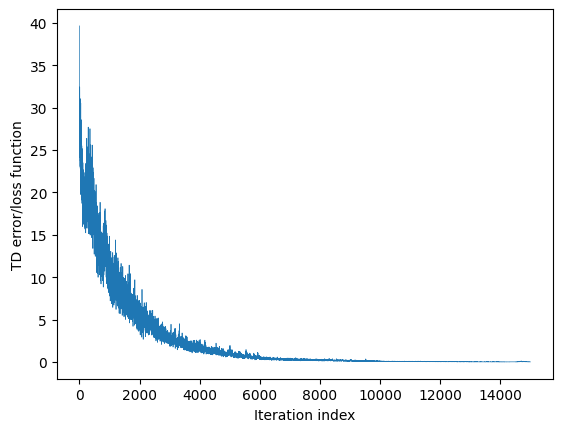

In [15]:
x_axis=[i for i in range(num_steps)]
plt.plot(x_axis, loss_list,linewidth = 0.5)
plt.xlabel('Iteration index')
plt.ylabel('TD error/loss function')
plt.show()

In [16]:
import matplotlib.patches as patches
def closed_form_solution2(action):

    
    P=np.zeros((state_num,state_num))
    R=np.zeros((state_num))
    for i in range(grid_c):
        for j in range(grid_r):
            next_r,next_c=i+dr[action[i,j]],j+dc[action[i,j]]
            s1=grid2s(i,j)
            if(next_r<0 or next_r>=grid_r or next_c<0 or next_c>=grid_c):
                P[s1,s1]=1
                R[s1]=r_boundary
            else:
                s2=grid2s(next_r,next_c)
                P[s1,s2]=1
                R[s1]=reward[next_r][next_c]

    I=np.eye(state_num)
    return np.linalg.inv(I-gamma*P)@R
    # print(V.reshape(grid_r,grid_c))
    # return np.sqrt(np.mean((V-V_target)**2))
v=closed_form_solution2(final_action.reshape((grid_r,grid_c)).numpy()).reshape((grid_r,grid_c))

print(v)

[[ 3.4867844   3.87420489  4.3046721   4.782969    5.31441   ]
 [ 3.13810596  3.4867844   4.782969    5.31441     5.9049    ]
 [ 2.82429536  2.54186583 10.          5.9049      6.561     ]
 [ 2.54186583 10.         10.         10.          7.29      ]
 [ 2.28767925  9.         10.          9.          8.1       ]]


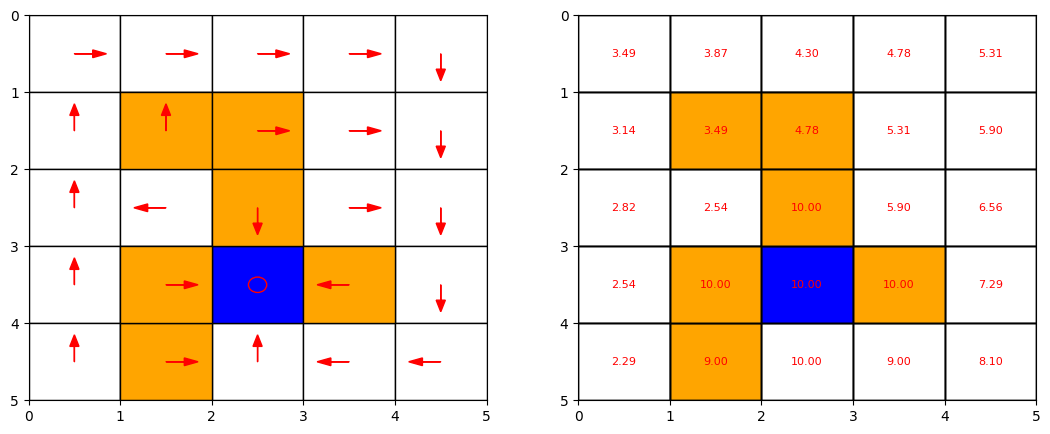

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
fig = plt.figure(figsize=(13, 5)) 
# 创建一个新的图形和坐标轴
ax1 = fig.add_subplot(121)

# 定义网格的大小
grid_size = 5

# 定义每个方格的大小
cell_size = 1


# 绘制网格
for i in range(grid_size):
    for j in range(grid_size):
        # 创建一个矩形
        rect = patches.Rectangle((j, i), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='white')
        # 将矩形添加到坐标轴
        ax1.add_patch(rect)

# 设置坐标轴的范围
ax1.set_xlim(0, grid_size)
ax1.set_ylim(0, grid_size)
rect = patches.Rectangle((2,3), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='blue')
ax1.add_patch(rect)

rect = patches.Rectangle((1,1), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='orange')
ax1.add_patch(rect)
rect = patches.Rectangle((2,1), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='orange')
ax1.add_patch(rect)
rect = patches.Rectangle((2,2), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='orange')
ax1.add_patch(rect)
rect = patches.Rectangle((1,4), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='orange')
ax1.add_patch(rect)
rect = patches.Rectangle((1,3), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='orange')
ax1.add_patch(rect)
rect = patches.Rectangle((3,3), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='orange')
ax1.add_patch(rect)


# 绘制网格
for i in range(grid_size):
    for j in range(grid_size):


        # 根据动作矩阵绘制箭头
        action_value = final_action.reshape((grid_r,grid_c))[i][j]
        center_x = j + cell_size / 2
        center_y = i + cell_size / 2

        if action_value == 0:  # 向上
            ax1.arrow(center_x, center_y, 0, -0.2, head_width=0.1, head_length=0.15, fc='red', ec='red')
        elif action_value == 1:  # 向右
            ax1.arrow(center_x, center_y, 0.2, 0, head_width=0.1, head_length=0.15, fc='red',ec='red')
        elif action_value == 2:  # 向下
            ax1.arrow(center_x, center_y, 0, 0.2, head_width=0.1, head_length=0.15, fc='red', ec='red')
        elif action_value == 3:  # 向左
            ax1.arrow(center_x, center_y, -0.2, 0, head_width=0.1, head_length=0.15, fc='red',ec='red')
        elif action_value == 4:  # 原地不动
            circle = patches.Circle((center_x, center_y), radius=0.1, fc='none', ec='red')
            ax1.add_patch(circle)

ax1.invert_yaxis()
# 显示图形


ax = fig.add_subplot(122)
grid_size = 5

# 定义每个方格的大小
cell_size = 1


# 绘制网格
for i in range(grid_size):
    for j in range(grid_size):
        # 创建一个矩形
        rect = patches.Rectangle((j, i), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='white')
        # 将矩形添加到坐标轴
        ax.add_patch(rect)

# 设置坐标轴的范围
ax.set_xlim(0, grid_size)
ax.set_ylim(0, grid_size)
rect = patches.Rectangle((2,3), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='blue')
ax.add_patch(rect)

rect = patches.Rectangle((1,1), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='orange')
ax.add_patch(rect)
rect = patches.Rectangle((2,1), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='orange')
ax.add_patch(rect)
rect = patches.Rectangle((2,2), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='orange')
ax.add_patch(rect)
rect = patches.Rectangle((1,4), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='orange')
ax.add_patch(rect)
rect = patches.Rectangle((1,3), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='orange')
ax.add_patch(rect)
rect = patches.Rectangle((3,3), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='orange')
ax.add_patch(rect)


for i in range(grid_size):
    for j in range(grid_size):
        # 创建一个矩形
        rect = patches.Rectangle((j, i), cell_size, cell_size, linewidth=1, edgecolor='black', facecolor='none')
        # 将矩形添加到坐标轴
        ax.add_patch(rect)

        # 在方格中心添加对应的数值
        value = v[i][j]
        center_x = j + cell_size / 2
        center_y = i + cell_size / 2
        ax.text(center_x, center_y, f"{value:.2f}", ha='center', va='center', fontsize=8,color='red')

ax.invert_yaxis()

# 显示图形
plt.show()